# Policy Gradient Voice Leading Draft 003

In [1]:
import copy

import random
import math
import numpy as np
from inspect import isfunction

import torch
print('Torch version:', torch.__version__)

import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

import matplotlib.pyplot as plt

from tqdm import tqdm

import sys

Torch version: 1.11.0


## Data preparation.
One of the key meta-features I want to implement in this new draft is some version of *translation invariance*.

Let $\mathcal{S}$ denote a fixed chromatic scale, meaning some subset of the $12$-TET scale. Because $\mathcal{S}$ is a chromatic scale, it has a natural ordering, which is to say that for any $s_1,s_2\in\mathcal{S}$, either $s_1\le s_2$ or $s_2\le s_1$. Fix a positive integer $n$, and let $\mathcal{Ch}_{n}\subset\mathcal{S}^{n}$ denote the subset
$$
\mathcal{Ch}_{n}
\ :=\ 
\big\{(s_1,s_2,\dots,s_n)\in\mathcal{S}^{n}:s_1\le s_2\le \cdots\le s_n\big\}.
$$
Assume that our scale $\mathcal{S}$ is of the form $\mathbb{Z}\cap[s_\text{low}, s_\text{high}]$, where $s_\text{low}$ is our lowest scale degree, and where $s_\text{high}$ is our highest scale degree.

### Class: `ChordDataset`
**Parent(s):** *none*

**What is does:** [...]

In [2]:
class ChordDataset():
    def __init__(self,
                 chord_size=3,
                 scale_range=[0,127]):
        super().__init__()
        
        self.chord_size = chord_size
        self.scale_range = scale_range
        
        self.scale_degree_list = [n for n in range(self.scale_range[0], self.scale_range[1]+1)]
        
        old_chords = [[]]
        for order in range(chord_size):
            new_chords = []
            for chord in tqdm(old_chords):
                for degree in self.scale_degree_list:
                    chord_with_new_degree = chord + [degree]
                    new_chords.append(chord_with_new_degree)
            old_chords = copy.deepcopy(new_chords)
        self.possible_chords = old_chords
        
        print('\nDataset consisting of {}-chords in scale-degree-range {} has been constructed as {}.\n'.format(self.chord_size, self.scale_range, self))

        
    def sample_batch(self,
                     batch_size=5):
        batch_of_samples = random.sample(self.possible_chords, batch_size)
        tensorized_batch = torch.LongTensor(batch_of_samples)
        
        return tensorized_batch

#### Testing:

In [3]:
chord_dataset = ChordDataset(chord_size=3,
                             scale_range=[0,127])

chord_dataset.sample_batch(batch_size=5)

100%|██████████████████████████████████| 16384/16384 [00:00<00:00, 17161.75it/s]



Dataset consisting of 3-chords in scale-degree-range [0, 127] has been constructed as <__main__.ChordDataset object at 0x7f7a0028aaf0>.



tensor([[101,  83,  62],
        [ 67,  51,  46],
        [ 98,  93,  35],
        [  0,   4,  36],
        [ 61, 111,  29]])

___

## Policy model.

### Class: `Policy_003`
**Parent(s):** `nn.Module`

**What is does:** [...]

**TODO**
* Residual and inter-branch connections.
* Layer (or batch) normalization.

In [4]:
class Policy_003(nn.Module):
    def __init__(self,
                 chord_size=3,
                 hidden_feature_count=500,
                 branch_feature_count=200,
                 main_layer_count=3,
                 branched_layer_count=3):
        
        super().__init__()
        
        assert isinstance(chord_size, int)
        assert chord_size > 0
        
        assert isinstance(hidden_feature_count, int)
        assert hidden_feature_count > 0
        
        assert isinstance(branch_feature_count, int)
        assert branch_feature_count > 0
        
        assert isinstance(main_layer_count, int)
        assert main_layer_count > 0
        
        assert isinstance(branched_layer_count, int)
        assert branched_layer_count > 0
        
        self.scale_degree_count = 128
        
        self.chord_size = chord_size
        self.hidden_feature_count = hidden_feature_count
        self.branch_feature_count = branch_feature_count
        self.main_layer_count = main_layer_count
        self.branched_layer_count = branched_layer_count
        
        # Embedding weight matrix is 128×128 tensor of one-hots
        self.weight = weight = F.one_hot(torch.arange(0, self.scale_degree_count)).type(torch.FloatTensor)

        # Embedding
        self.embedding = nn.Embedding.from_pretrained(weight)
        
        self.main_layers = nn.ModuleList(modules=None)
        self.main_layers.append(nn.Linear(2 * self.scale_degree_count, self.hidden_feature_count))
        nn.init.kaiming_normal_(self.main_layers[-1].weight, mode='fan_in', nonlinearity='leaky_relu')
        for n in range(self.main_layer_count-1):
            self.main_layers.append(nn.Linear(self.hidden_feature_count, self.hidden_feature_count))
            nn.init.kaiming_normal_(self.main_layers[-1].weight, mode='fan_in', nonlinearity='leaky_relu')
        
        self.main_layers_activation = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        
        self.branches_listings = nn.ModuleList(modules=None)
        for n in range(self.chord_size):
            self.branches_listings.append(nn.ModuleList(modules=None))
            self.branches_listings[-1].append(nn.Linear(self.hidden_feature_count, self.branch_feature_count))
            nn.init.kaiming_normal_(self.branches_listings[-1][-1].weight, mode='fan_in', nonlinearity='leaky_relu')
            for i in range(self.branched_layer_count-2):
                self.branches_listings[-1].append(nn.Linear(self.branch_feature_count, self.branch_feature_count))
                nn.init.kaiming_normal_(self.branches_listings[-1][-1].weight, mode='fan_in', nonlinearity='leaky_relu')
            self.branches_listings[-1].append(nn.Linear(self.branch_feature_count, self.scale_degree_count))
            nn.init.normal_(self.branches_listings[-1][-1].weight, mean=0, std=0.01)
            fan_in = self.branches_listings[-1][-1].weight.size(1)
            scale = math.sqrt(1 / fan_in)
            self.branches_listings[-1][-1].weight.data *= scale
            
        self.branch_layers_activation = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        
        self.branch_softmax = nn.Softmax(dim=-1)
        
        
    def forward(self, batched_X, batched_final):
        batched_onehots_X = self.embedding(batched_X)
        batched_summed_X = torch.sum(batched_onehots_X, dim=1)
        
        batched_onehots_final = self.embedding(batched_final)
        batched_summed_final = torch.sum(batched_onehots_final, dim=1)
        
        next_layer_input = torch.cat((batched_summed_X, batched_summed_final), dim=-1)
        for j, layer in enumerate(self.main_layers):
            if j == 0:
                pre_activation = layer(next_layer_input)
                next_layer_input = self.main_layers_activation(pre_activation)
            else:
                previous_layer_input = next_layer_input
                pre_activation = layer(next_layer_input)
                next_layer_input = self.main_layers_activation(pre_activation) + previous_layer_input
            
        branch_input = next_layer_input
            
        for k, branch in enumerate(self.branches_listings):
            
            for i, branch_layer in enumerate(branch):
                
                if i == 0:
                    branch_pre_activation = branch_layer(branch_input)
                    next_branch_layer_input = self.branch_layers_activation(branch_pre_activation)
                # The upper limimt of `self.branched_layer_count-1` is important here,
                # because it ensures that we get one more pass through a layer afterward...
                
                elif 1 < i < self.branched_layer_count-1:
                    previous_branch_layer_input = next_branch_layer_input
                    branch_pre_activation = branch_layer(next_branch_layer_input)
                    next_branch_layer_input = self.branch_layers_activation(branch_pre_activation) + previous_branch_layer_input
                # ...giving us the following softmax, which will let us interpret the model as a policy function:
                
                else:
                    branch_pre_activation = branch_layer(next_branch_layer_input)
                    next_branch_layer_input = self.branch_softmax(branch_pre_activation)
            
            if k == 0:
                
                output = next_branch_layer_input
                
            else:
                
                # Generate Einstein summation equation string:
                left_string = 'ab,a'
                right_string = ''
                for l in range(k):
                    left_string += '{}'.format(chr(97+2+l))
                for l in range(k+2):
                    right_string += '{}'.format(chr(97+l))
                summation_equation = left_string + '->' + right_string
                
                # Compute outer-product tensor for Einstein summation equation generated immediately above:
                output = torch.einsum(summation_equation, next_branch_layer_input, output)
        
        return output

#### Testing:

In [5]:
policy_003 = Policy_003(chord_size=3,
                        hidden_feature_count=500,
                        main_layer_count=5)

#print(policy_003.embedding)

#print(policy_003.branches_listings)

X = torch.LongTensor([[23, 45, 47], [26, 46, 53], [32, 49, 54], [35, 51, 55], [37, 53, 58]])
final = torch.LongTensor([[32, 49, 54], [26, 46, 53], [35, 51, 55], [23, 45, 47], [37, 53, 58]])

output = policy_003(X, final)

print(output.size())
print(torch.sum(output, dim=(1,2,3)))

torch.Size([5, 128, 128, 128])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


### Function: `maximizing_index`

**What is does:** [...]

In [6]:
def maximizing_index(distribution_tensor):
    depth = len(distribution_tensor.size())

    running_indices = []
    for d in range(depth):
        distribution_tensor, indices = distribution_tensor.max(dim=-1)
        running_indices.append(indices)

    maximizing_index = []
    for i in range(len(running_indices)):
        indexing_tensor = running_indices[-(1+i)].unsqueeze(-1)
        for j in maximizing_index:
            indexing_tensor = indexing_tensor[j]
        current_index = indexing_tensor.item()
        maximizing_index.append(current_index)
    
    return maximizing_index

#### Testing:

In [7]:
X = torch.Tensor([[[-1.,1.], [2., -3.]],[[2., 5.], [1., 1.]]])
Y = copy.deepcopy(X)

print(maximizing_index(X))

for j in maximizing_index(X):
    Y = Y[j]
print(Y)

[1, 0, 1]
tensor(5.)


### Function: `batched_maximizing_indices`

**What is does:** [...]

In [8]:
def batched_maximizing_indices(batched_distribution_tensors):
    batched_indices = []
    for k in range(len(batched_distribution_tensors)):
        distribution_tensor = batched_distribution_tensors[k]
        current_indices = maximizing_index(distribution_tensor)
        batched_indices.append(current_indices)
        
        tensorized_batched_indices = torch.LongTensor(batched_indices)
        
    return tensorized_batched_indices

#### Testing:

In [9]:
batch = torch.Tensor([[[[-1.,1.], [2., -3.]],[[2., 5.], [1., 1.]]],
                      [[[0.,7.], [2., -3.]],[[2., 5.], [1., 1.]]],
                      [[[-1.,4.], [2., -3.]],[[2., 5.], [8., 1.]]]])

batched_maximizing_indices(batch)

tensor([[1, 0, 1],
        [0, 0, 1],
        [1, 1, 0]])

#### Testing output of forward pass of `Policy_003` as input for `batched_maximizing_indices`:

In [10]:
policy_003 = Policy_003(chord_size=3,
                        hidden_feature_count=500,
                        main_layer_count=5)

#print(policy_003.embedding)

#print(policy_003.branches_listings)

X = torch.LongTensor([[23, 45, 47], [26, 46, 53], [32, 49, 54], [35, 51, 55], [37, 53, 58]])
final = torch.LongTensor([[32, 49, 54], [26, 46, 53], [35, 51, 55], [23, 45, 47], [37, 53, 58]])

output = policy_003(X, final)

batched_maximizing_indices(output)

tensor([[ 49,  43, 101],
        [ 49,  43, 101],
        [ 49,  43, 101],
        [ 49,  43, 101],
        [ 49,  43, 101]])

#### Testing `Policy_003` forward pass output on `ChordDataset` samples as input for `batched_maximizing_indices`:

In [11]:
chord_dataset = ChordDataset(chord_size=3,
                             scale_range=[0,127])

state_batch = chord_dataset.sample_batch(batch_size=5)
final_batch = chord_dataset.sample_batch(batch_size=5)

policy_003 = Policy_003(chord_size=3,
                        hidden_feature_count=500,
                        main_layer_count=5)

output = policy_003(state_batch, final_batch)

batched_maximizing_indices(output)

100%|██████████████████████████████████| 16384/16384 [00:00<00:00, 19296.61it/s]



Dataset consisting of 3-chords in scale-degree-range [0, 127] has been constructed as <__main__.ChordDataset object at 0x7f79f002e2b0>.



tensor([[65, 76, 46],
        [65, 76, 46],
        [65, 76, 46],
        [65, 76, 46],
        [65, 76, 46]])

### Function: `select_policy_output`

**What it does.**

In [12]:
def select_policy_output(policy_batch, state_batch):
    
    assert len(policy_batch) == len(state_batch)
    assert state_batch.size()[-1] == len(policy_batch.size())-1
    
    rank = state_batch.size()[-1]
    list_of_coordinates = state_batch.tolist()
    
    policy_value_batch = torch.Tensor([])
    for batch_index, coordinates in enumerate(list_of_coordinates):
        policy_array = policy_batch[batch_index]
        for n in coordinates:
            policy_array = policy_array[n]
        policy_array = policy_array.unsqueeze(0)
        policy_value_batch = torch.cat((policy_value_batch, policy_array),dim=0)    
    
    return policy_value_batch

Testing:

In [30]:
policy_output = agent.policy_outputs_batch[-1]
state_output = agent.episode_states_batch[-1]
selection = select_policy_output(policy_output, state_output)
print(selection)

NameError: name 'agent' is not defined

___

## Reward functions & classes.

### Function: `progress_to_closing`

In [19]:
def progress_to_closing(episode_states_batch, final_batch, reward_weight = 1.):
    start_batch = episode_states_batch[-2]
    action_batch = episode_states_batch[-1]
    
    start_order = start_batch.size()[-1]
    start_centroid = torch.sum(start_batch, dim=-1)/start_order
    
    action_order = action_batch.size()[-1]
    action_centroid = torch.sum(action_batch, dim=-1)/action_order
    
    centroid_movement = action_centroid - start_centroid
    centroid_movement_sign = torch.sign(centroid_movement)
    
    final_order = final_batch.size()[-1]
    final_centroid = torch.sum(final_batch, dim=-1)/final_order
    
    centroid_draw = final_centroid - start_centroid
    centroid_draw_sign = torch.sign(centroid_draw)
    
    reward_batch = centroid_movement_sign * centroid_draw_sign
    weighted_reward_batch = reward_weight * reward_batch
    
    return weighted_reward_batch

Testing:

In [20]:
X_batch = torch.Tensor([[[1, 0, 1], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 0, 1]],
                        [[1, -1, 1], [-1, 3, 1], [1, 1, 2], [1, 4, 1], [0, -2, 1]]])
Z = torch.Tensor([[1, -2, 1], [0, 2, 1], [1, 1, 5], [1, -4, 1], [3, 3, 1]])

progress_to_closing(X_batch, Z)

tensor([ 1.,  1.,  1., -1., -1.])

### Function: `closing_chord`

In [21]:
def closing_chord(episode_states_batch, final_batch, reward_weight = 20.):
    start_batch = episode_states_batch[-2]
    action_batch = episode_states_batch[-1]
    
    entrywise_match_check = (action_batch == final_batch)
    
    reward_batch = torch.prod(entrywise_match_check, dim=-1).to(torch.float)
    weighted_reward_batch = reward_weight * reward_batch
    
    return weighted_reward_batch

Testing:

In [22]:
X_batch = torch.Tensor([[[1, 0, 1], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 0, 1]],
                        [[1, -1, 1], [-1, 3, 1], [1, 1, 2], [1, 4, 1], [0, -2, 1]]])
Z = torch.Tensor([[1, -2, 1], [-1, 3, 1], [1, 1, 5], [1, 4, 1], [3, 3, 1]])

closing_chord(X_batch, Z)

tensor([ 0., 20.,  0., 20.,  0.])

### Class: `AllRewards`
**Parent(s):** *none*

**What it does:**

In [23]:
class AllRewards():
    def __init__(self,
                 *args):
        
        for argument in args:
            assert isfunction(argument)
        
        self.args = args
        
    
    def total_reward(self, episode_states_batch, final_batch):
        
        for episode_batch in episode_states_batch:
            assert len(episode_batch) == len(final_batch)
            batch_length = len(episode_batch)
        
        running_reward = torch.Tensor([0. for _ in range(batch_length)])
        for reward_function in self.args:
            new_reward = reward_function(episode_states_batch, final_batch)
            running_reward = torch.add(running_reward, new_reward)
            
        return running_reward

Testing:

In [24]:
all_rewards = AllRewards(progress_to_closing, closing_chord)

X_batch = torch.Tensor([[[1, 0, 1], [0, 0, 1], [1, 1, 0], [1, 0, 1], [0, 0, 1]],
                        [[1, -1, 1], [-1, 3, 1], [1, 1, 2], [1, 4, 1], [0, -2, 1]]])
print(len(X_batch))
Z = torch.Tensor([[1, -2, 1], [-1, 3, 1], [1, 1, 5], [1, 4, 1], [3, 3, 1]])
print(len(Z))

all_rewards.args[1](X_batch, Z)

all_rewards.total_reward(X_batch, Z)

2
5


tensor([ 1., 21.,  1., 21., -1.])

___

## Agent class.

### Class: `Agent`
**Parent(s):** *none*

**What is does:** [...]

In [25]:
class Agent():
    def __init__(self,
                 chord_size=2,
                 starting_chord_batch=torch.LongTensor([[63,68],[45, 49]]),
                 final_chord_batch=torch.LongTensor([[60, 64],[70, 74]]),
                 policy=Policy_003(chord_size=3),
                 rewards=AllRewards(progress_to_closing, closing_chord),
                 chord_dataset=chord_dataset):
        
        assert chord_size == policy.chord_size
        
        assert len(starting_chord_batch) == len(final_chord_batch)
        for chord in starting_chord_batch:
            assert len(chord) == chord_size
        for chord in final_chord_batch:
            assert len(chord) == chord_size
        
        assert isinstance(policy, Policy_003)
        assert isinstance(rewards, AllRewards)
        
        assert chord_size == chord_dataset.chord_size
        
        self.chord_size = chord_size
        
        self.starting_chord_batch = starting_chord_batch
        self.final_chord_batch = final_chord_batch
        
        self.batch_length = len(starting_chord_batch)
        
        self.policy = policy
        self.rewards = rewards
        self.chord_dataset = chord_dataset
        
        in_string = ''
        for l in range(self.chord_size):
            in_string += ',{}'.format(chr(97+1+l))
        in_string = in_string[1:]
        out_string = ''
        for l in range(self.chord_size):
            out_string += '{}'.format(chr(97+1+l))
        summation_string = in_string + '->' + out_string
        
        starting_list = self.starting_chord_batch.tolist()
        initial_distribution_batch = torch.Tensor([])
        for chord in starting_list:
            chord_onehots = []
            for entry in chord:
                onehot = torch.Tensor([float(i == entry) for i in range(self.policy.scale_degree_count)])
                chord_onehots.append(onehot)
            starting_distribution = torch.einsum(summation_string, chord_onehots).unsqueeze(0)
            initial_distribution_batch = torch.cat((initial_distribution_batch, starting_distribution),dim=0)
                
        self.policy_outputs_batch = initial_distribution_batch.unsqueeze(0)
        self.episode_states_batch = self.starting_chord_batch.unsqueeze(0)
        self.specific_policy_batch = torch.Tensor([[1. for _ in range(self.batch_length)]])
        self.episode_rewards_batch = torch.Tensor([[0. for _ in range(self.batch_length)]])
        self.episode_returns_batch = torch.Tensor([[0. for _ in range(self.batch_length)]])
        
        
    def time_step(self, noise_probability=.1):
        
        input_batch = self.episode_states_batch[-1]
        
        distribution_batch = self.policy(input_batch, self.final_chord_batch)
        self.policy_outputs_batch = torch.cat((self.policy_outputs_batch, distribution_batch.unsqueeze(0)), dim=0)
        
        random_sample_query = random.choices([0, 1], weights=(1-noise_probability, noise_probability), k=1)
        current_policy_batch = self.policy_outputs_batch[-1]
        if random_sample_query == [1]:
            action_batch = self.chord_dataset.sample_batch(batch_size=self.batch_length).unsqueeze(0)
            self.episode_states_batch = torch.cat((self.episode_states_batch, action_batch), dim=0)
            self.episode_states_batch = self.episode_states_batch.detach()
            current_policy_batch = select_policy_output(current_policy_batch, self.episode_states_batch[-1])
            current_policy_batch = current_policy_batch.unsqueeze(0)
            self.specific_policy_batch = torch.cat((self.specific_policy_batch, current_policy_batch), dim=0)
        else:
            action_batch = batched_maximizing_indices(distribution_batch).unsqueeze(0)
            self.episode_states_batch = torch.cat((self.episode_states_batch, action_batch), dim=0)
            self.episode_states_batch = self.episode_states_batch.detach()
            for d in range(self.chord_size):
                current_policy_batch = current_policy_batch.max(dim=-1)[0]
            current_policy_batch = current_policy_batch.unsqueeze(0)
            self.specific_policy_batch = torch.cat((self.specific_policy_batch, current_policy_batch), dim=0)
        
        reward_batch = self.rewards.total_reward(self.episode_states_batch, self.final_chord_batch).unsqueeze(0)
        self.episode_rewards_batch = torch.cat((self.episode_rewards_batch, reward_batch), dim=0)
        self.episode_rewards_batch = self.episode_rewards_batch.detach()
        
        self.episode_returns_batch = self.episode_returns_batch + reward_batch
        self.episode_returns_batch = torch.cat((self.episode_returns_batch, reward_batch), dim=0)
        self.episode_returns_batch = self.episode_returns_batch.detach()

Testing:

In [26]:
chord_dataset = ChordDataset(chord_size=2)
agent = Agent(chord_size = 2, policy=Policy_003(chord_size=2), chord_dataset=chord_dataset)

100%|██████████████████████████████████████| 128/128 [00:00<00:00, 31456.67it/s]


Dataset consisting of 2-chords in scale-degree-range [0, 127] has been constructed as <__main__.ChordDataset object at 0x7f79f002ecd0>.



In [27]:
for _ in range(20):
    agent.time_step()
print('\nShape of policy batch:\n', agent.policy_outputs_batch.size())
print('Requires grad:', agent.policy_outputs_batch.requires_grad)
print('\nShape of states batch:\n', agent.episode_states_batch)
print('Requires grad:', agent.episode_states_batch.requires_grad)
print('\nShape of specific policy batch:\n', agent.specific_policy_batch)
print('Requires grad:', agent.specific_policy_batch.requires_grad)
print('\nShape of rewards batch:\n', agent.episode_rewards_batch.size())
print('Requires grad:', agent.episode_rewards_batch.requires_grad)
print('\nShape of returns batch:\n', agent.epsiode_returns_batch.size())
print('Requires grad:', agent.epsiode_returns_batch.requires_grad)


Shape of policy batch:
 torch.Size([21, 2, 128, 128])
Requires grad: True

Shape of states batch:
 tensor([[[ 63,  68],
         [ 45,  49]],

        [[  3,  28],
         [  3,  28]],

        [[ 80, 121],
         [ 49,  48]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[ 88,  83],
         [ 89,   5]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],
         [  3,  28]],

        [[  3,  28],

AttributeError: 'Agent' object has no attribute 'epsiode_returns_batch'

___

## Training

In [28]:
chord_size = 1
chord_dataset = ChordDataset(chord_size=chord_size, scale_range=[0,127])
policy=Policy_003(chord_size=chord_size)

loss_values = []
return_values = []

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 5614.86it/s]


Dataset consisting of 1-chords in scale-degree-range [0, 127] has been constructed as <__main__.ChordDataset object at 0x7f7a43604c10>.



  0%|                                    | 31/100000 [00:16<14:11:44,  1.96it/s]


Loss > 500 at episode  31
tensor([[[78],
         [46],
         [91],
         [76],
         [25]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        ...,

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [21., -1.,  1., -1.,  1.],
        [20.,  0.,  0.,  0.,  0.],
        ...,
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.]])
tensor([[3640.,   36.,   31.,   19.,   27.],
        [3640.,   36.,   31.,   19.,   27.],
        [3619.,   37.,   30.,   20.,   26.],
        ...,
        [  60.,    0.,    0.,    0.,    0.],
        [  40.,    0.,    0.,    0.,    0.],
        [  20.,    0.,    0.,    0.

  0%|                                    | 49/100000 [00:25<14:44:59,  1.88it/s]


Loss > 500 at episode  49
tensor([[[ 31],
         [106],
         [105],
         [ 90],
         [ 67]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  1.,  1., 21.],
        [ 0.,  0.,  0.,  0., 20.],
        ...,
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.]])
tensor([[  10.,   14.,   26.,   10., 3695.],
        [  10.,   14.,   26.,   10., 3695.],
        [  11.,   13.,   25.,    9., 3674.],
        ...,
        [   0.,    0.,    0.,    0.,   60.],
        [   0.,    0.,    0.,    0.,   40.],
     

  0%|                                   | 143/100000 [01:14<14:08:38,  1.96it/s]


Loss > 500 at episode  143
tensor([[[ 26],
         [  3],
         [ 72],
         [106],
         [102]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[110],
         [127],
         [ 96],
         [ 30],
         [ 11]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [20.,  1.,  1.,  1.,  1.],
        [20.,  0.,  0.,  0.,  0.],
        ...,
        [ 0.,  1., -1., -1.,  1.],
        [21.,  1.,  1.,  1.,  1.],
        [20.,  0.,  0.,  0.,  0.]])
tensor([[3.4470e+03, 7.0000e+00, 7.0000e+00, 2.2000e+01, 1.3000e+01],
        [3.4470e+03, 7.0000e+00, 7.0000e+00, 2.2000e+01, 1.3000e+01],
        [3.4270e+03, 6.0000e+00, 6.0000e+00, 2.1000e+01, 1.2000e+01],
        ...,
        [4.1000e+01

  0%|                                   | 177/100000 [01:31<14:07:59,  1.96it/s]


Loss > 500 at episode  177
tensor([[[ 69],
         [ 46],
         [ 65],
         [122],
         [116]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1., 21.],
        [ 0.,  0.,  0.,  0., 20.],
        ...,
        [ 1.,  1.,  1.,  1., 21.],
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.]])
tensor([[1.4000e+01, 2.6000e+01, 4.0000e+00, 4.0000e+00, 3.6550e+03],
        [1.4000e+01, 2.6000e+01, 4.0000e+00, 4.0000e+00, 3.6550e+03],
        [1.3000e+01, 2.5000e+01, 3.0000e+00, 3.0000e+00, 3.6340e+03],
        ...,
        [1.0000e+00

  0%|                                   | 191/100000 [01:38<14:09:07,  1.96it/s]


Loss > 500 at episode  191
tensor([[[31],
         [30],
         [41],
         [25],
         [52]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        ...,

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., 21.],
        [ 0.,  0.,  0.,  0., 20.],
        ...,
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.]])
tensor([[ 2.0000e+01,  1.8000e+01,  1.6000e+01, -2.0000e+00,  3.5830e+03],
        [ 2.0000e+01,  1.8000e+01,  1.6000e+01, -2.0000e+00,  3.5830e+03],
        [ 2.1000e+01,  1.9000e+01,  1.7000e+01, -1.0000e+00,  3.5620e+03],
        ...,
        [ 0.0000e+00,  0.0000e+00,

  0%|                                   | 200/100000 [01:43<14:09:40,  1.96it/s]


Loss > 500 at episode  200
tensor([[[ 26],
         [ 75],
         [ 82],
         [ 69],
         [103]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 0., -1., -1., -1., 21.],
        [ 0.,  0.,  0.,  0., 20.],
        ...,
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.]])
tensor([[1.2000e+01, 5.0000e+00, 7.0000e+00, 1.0000e+00, 3.7160e+03],
        [1.2000e+01, 5.0000e+00, 7.0000e+00, 1.0000e+00, 3.7160e+03],
        [1.2000e+01, 6.0000e+00, 8.0000e+00, 2.0000e+00, 3.6950e+03],
        ...,
        [0.0000e+00

  0%|                                   | 204/100000 [01:45<14:08:34,  1.96it/s]


Loss > 500 at episode  204
tensor([[[101],
         [117],
         [ 73],
         [ 51],
         [ 22]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [-1.,  1., 21.,  1.,  1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.]])
tensor([[1.0000e+00, 4.0000e+00, 3.6950e+03, 4.0000e+00, 2.0000e+00],
        [1.0000e+00, 4.0000e+00, 3.6950e+03, 4.0000e+00, 2.0000e+00],
        [2.0000e+00, 3.0000e+00, 3.6740e+03, 3.0000e+00, 1.0000e+00],
        ...,
        [0.0000e+00

  0%|                                   | 335/100000 [02:53<14:07:44,  1.96it/s]


Loss > 500 at episode  335
tensor([[[126],
         [ 71],
         [  6],
         [ 66],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 76],
         [  8],
         [ 79],
         [ 33],
         [118]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1., 20.],
        [ 0.,  0.,  0.,  0., 20.],
        ...,
        [ 1.,  1., -1.,  1., -1.],
        [ 1., -1.,  1., -1., 21.],
        [ 0.,  0.,  0.,  0., 20.]])
tensor([[ 5.4000e+01,  2.4000e+01,  2.2000e+01,  4.8000e+01,  3.5970e+03],
        [ 5.4000e+01,  2.4000e+01,  2.2000e+01,  4.8000e+01,  3.5970e+03],
        [ 5.3000e+01,  2.3000e+01,  2.1000e+01,  4.7000e+01,  3.5770e+03],
        ...,
    

  0%|                                   | 342/100000 [02:57<14:23:21,  1.92it/s]


Loss > 500 at episode  342
tensor([[[106],
         [ 90],
         [ 66],
         [ 20],
         [  2]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1., 21.,  1.,  1.,  1.],
        [ 0., 20.,  0.,  0.,  0.],
        ...,
        [ 0., 20.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.]])
tensor([[  37., 3505.,    5.,   15.,    7.],
        [  37., 3505.,    5.,   15.,    7.],
        [  36., 3484.,    4.,   14.,    6.],
        ...,
        [   0.,   60.,    0.,    0.,    0.],
        [   0.,   40.,    0.,    0.,    0.],
    

  0%|                                   | 345/100000 [02:59<14:17:30,  1.94it/s]


Loss > 500 at episode  345
tensor([[[  2],
         [ 93],
         [ 36],
         [112],
         [ 42]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[  0],
         [100],
         [127],
         [ 25],
         [110]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  0., -1.,  1., 21.],
        [ 0.,  0.,  0.,  0., 20.],
        ...,
        [-1.,  1.,  1., -1.,  0.],
        [ 1.,  1.,  1.,  1., 21.],
        [ 0.,  0.,  0.,  0., 20.]])
tensor([[1.4000e+01, 9.0000e+00, 1.4000e+01, 2.4000e+01, 3.6910e+03],
        [1.4000e+01, 9.0000e+00, 1.4000e+01, 2.4000e+01, 3.6910e+03],
        [1.3000e+01, 9.0000e+00, 1.5000e+01, 2.3000e+01, 3.6700e+03],
        ...,
        [0.0000e+00

  0%|▏                                  | 417/100000 [03:36<14:14:44,  1.94it/s]


Loss > 500 at episode  417
tensor([[[75],
         [ 0],
         [40],
         [15],
         [11]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        ...,

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [21.,  1., -1.,  1.,  1.],
        [20.,  0.,  0.,  0.,  0.],
        ...,
        [21.,  1.,  1., -1., -1.],
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.]])
tensor([[ 3.6570e+03,  3.2000e+01,  2.0000e+01,  0.0000e+00,  1.0000e+01],
        [ 3.6570e+03,  3.2000e+01,  2.0000e+01,  0.0000e+00,  1.0000e+01],
        [ 3.6360e+03,  3.1000e+01,  2.1000e+01, -1.0000e+00,  9.0000e+00],
        ...,
        [ 6.1000e+01,  1.0000e+00,

  0%|▏                                  | 462/100000 [03:59<14:08:02,  1.96it/s]


Loss > 500 at episode  462
tensor([[[105],
         [ 98],
         [ 39],
         [113],
         [ 80]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1., 21.,  1., -1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.]])
tensor([[  22.,   22., 3696.,   16.,    4.],
        [  22.,   22., 3696.,   16.,    4.],
        [  21.,   21., 3675.,   15.,    5.],
        ...,
        [   0.,    0.,   60.,    0.,    0.],
        [   0.,    0.,   40.,    0.,    0.],
    

  0%|▏                                  | 500/100000 [04:19<14:06:50,  1.96it/s]

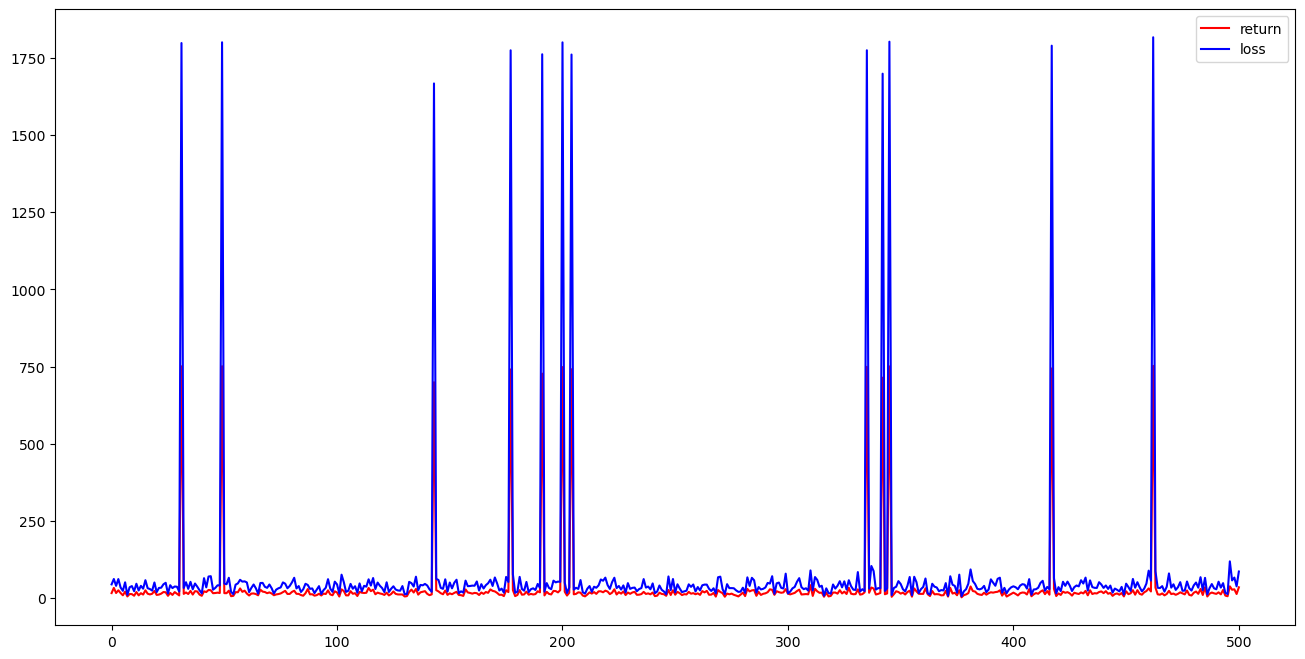

  1%|▏                                  | 570/100000 [04:55<14:14:39,  1.94it/s]


Loss > 500 at episode  570
tensor([[[ 14],
         [ 62],
         [  4],
         [ 97],
         [100]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[117],
         [ 33],
         [102],
         [ 51],
         [ 86]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [21.,  1.,  1.,  1.,  1.],
        [20.,  0.,  0.,  0.,  0.],
        ...,
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -1., -1.,  1.]])
tensor([[ 3.6370e+03,  6.2000e+01,  6.0000e+00, -1.0000e+00,  3.9000e+01],
        [ 3.6370e+03,  6.2000e+01,  6.0000e+00, -1.0000e+00,  3.9000e+01],
        [ 3.6160e+03,  6.1000e+01,  5.0000e+00, -2.0000e+00,  3.8000e+01],
        ...,
    

  1%|▏                                  | 573/100000 [04:57<14:13:09,  1.94it/s]


Loss > 500 at episode  573
tensor([[[ 54],
         [116],
         [ 99],
         [ 87],
         [ 47]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1., 21.,  1.,  1.,  1.],
        [ 0., 20.,  0.,  0.,  0.],
        ...,
        [ 1., 21.,  1.,  1.,  1.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.]])
tensor([[1.0000e+00, 3.5830e+03, 3.3000e+01, 1.0000e+00, 9.0000e+00],
        [1.0000e+00, 3.5830e+03, 3.3000e+01, 1.0000e+00, 9.0000e+00],
        [0.0000e+00, 3.5620e+03, 3.2000e+01, 0.0000e+00, 8.0000e+00],
        ...,
        [1.0000e+00

  1%|▏                                  | 600/100000 [05:10<14:14:05,  1.94it/s]


Loss > 500 at episode  600
tensor([[[ 51],
         [101],
         [ 93],
         [102],
         [ 89]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 51],
         [ 83],
         [ 10],
         [ 31],
         [116]],

        [[100],
         [ 94],
         [ 24],
         [ 79],
         [ 65]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [-1., -1.,  1.,  1., 21.],
        [ 0.,  0.,  0.,  0., 20.],
        ...,
        [ 0.,  0.,  0.,  0., 20.],
        [ 1.,  1., -1., -1.,  0.],
        [ 1.,  1.,  1., -1.,  1.]])
tensor([[ 7.0000e+00,  2.0000e+01,  3.4000e+01,  1.0000e+00,  3.7130e+03],
        [ 7.0000e+00,  2.0000e+01,  3.4000e+01,  1.0000e+00,  3.7130e+03],
        [ 8.0000e+00,  2.1000e+01,  3.3000e+01,  0.0000e+00,  3.6920e+03],
        ...,
    

  1%|▏                                  | 602/100000 [05:12<14:16:26,  1.93it/s]


Loss > 500 at episode  602
tensor([[[16],
         [39],
         [22],
         [53],
         [25]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        ...,

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1., -1., 21.,  1.,  1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.]])
tensor([[1.0000e+00, 1.5000e+01, 3.5050e+03, 5.2000e+01, 3.8000e+01],
        [1.0000e+00, 1.5000e+01, 3.5050e+03, 5.2000e+01, 3.8000e+01],
        [0.0000e+00, 1.6000e+01, 3.4840e+03, 5.1000e+01, 3.7000e+01],
        ...,
        [0.0000e+00, 0.0000e+00, 6.0000e+01, 0.00

  1%|▏                                  | 651/100000 [05:37<14:06:43,  1.96it/s]


Loss > 500 at episode  651
tensor([[[ 92],
         [ 76],
         [  6],
         [ 12],
         [107]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 58],
         [ 28],
         [ 45],
         [ 48],
         [100]],

        ...,

        [[ 65],
         [ 39],
         [107],
         [126],
         [ 47]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1., 21.,  1.],
        [ 1., -1.,  1.,  0.,  1.],
        ...,
        [ 1., -1.,  1.,  0.,  1.],
        [-1.,  1.,  1., 21.,  1.],
        [ 0.,  0.,  0., 20.,  0.]])
tensor([[ 1.8000e+01,  1.0000e+01,  2.6000e+01,  3.5410e+03,  3.6000e+01],
        [ 1.8000e+01,  1.0000e+01,  2.6000e+01,  3.5410e+03,  3.6000e+01],
        [ 1.7000e+01,  9.0000e+00,  2.5000e+01,  3.5200e+03,  3.5000e+01],
        ...,
    

  1%|▏                                  | 653/100000 [05:38<14:10:27,  1.95it/s]


Loss > 500 at episode  653
tensor([[[ 43],
         [114],
         [ 27],
         [ 32],
         [ 73]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1., -1., 21., -1., -1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.]])
tensor([[3.0000e+00, 1.0000e+00, 3.7350e+03, 1.7000e+01, 9.0000e+00],
        [3.0000e+00, 1.0000e+00, 3.7350e+03, 1.7000e+01, 9.0000e+00],
        [2.0000e+00, 2.0000e+00, 3.7140e+03, 1.8000e+01, 1.0000e+01],
        ...,
        [0.0000e+00

  1%|▏                                  | 659/100000 [05:41<14:11:45,  1.94it/s]


Loss > 500 at episode  659
tensor([[[107],
         [ 27],
         [ 36],
         [  6],
         [100]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[104],
         [108],
         [ 73],
         [ 90],
         [112]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1., -1., 21.,  1.],
        [ 0.,  0.,  0., 20.,  0.],
        ...,
        [ 0.,  0.,  0., 20.,  0.],
        [ 1., -1.,  1.,  0.,  1.],
        [ 1.,  1., -1., 21.,  1.]])
tensor([[ 1.1000e+01,  3.0000e+00,  9.0000e+00,  3.7350e+03,  1.5000e+01],
        [ 1.1000e+01,  3.0000e+00,  9.0000e+00,  3.7350e+03,  1.5000e+01],
        [ 1.0000e+01,  2.0000e+00,  1.0000e+01,  3.7140e+03,  1.4000e+01],
        ...,
    

  1%|▎                                  | 725/100000 [06:15<14:05:49,  1.96it/s]


Loss > 500 at episode  725
tensor([[[ 61],
         [ 11],
         [ 72],
         [ 84],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 75],
         [ 76],
         [ 33],
         [122],
         [ 82]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [21.,  1., -1.,  1.,  0.],
        [20.,  0.,  0.,  0.,  0.],
        ...,
        [20.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  1.,  1.,  1.],
        [21., -1., -1.,  1.,  1.]])
tensor([[ 3.6760e+03,  2.0000e+01,  2.0000e+00,  2.6000e+01,  7.0000e+00],
        [ 3.6760e+03,  2.0000e+01,  2.0000e+00,  2.6000e+01,  7.0000e+00],
        [ 3.6550e+03,  1.9000e+01,  3.0000e+00,  2.5000e+01,  7.0000e+00],
        ...,
    

  1%|▎                                  | 736/100000 [06:21<14:10:36,  1.94it/s]


Loss > 500 at episode  736
tensor([[[78],
         [87],
         [83],
         [18],
         [93]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        ...,

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [21.,  1.,  1.,  1., -1.],
        [20.,  0.,  0.,  0.,  0.],
        ...,
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.]])
tensor([[3.6020e+03, 2.8000e+01, 3.0000e+01, 2.6000e+01, 2.0000e+00],
        [3.6020e+03, 2.8000e+01, 3.0000e+01, 2.6000e+01, 2.0000e+00],
        [3.5810e+03, 2.7000e+01, 2.9000e+01, 2.5000e+01, 3.0000e+00],
        ...,
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 0.00

  1%|▎                                  | 744/100000 [06:25<14:06:04,  1.96it/s]


Loss > 500 at episode  744
tensor([[[ 82],
         [ 25],
         [ 46],
         [ 11],
         [ 28]],

        [[ 35],
         [114],
         [ 49],
         [ 76],
         [111]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 83],
         [103],
         [122],
         [ 55],
         [ 41]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1.,  1.,  1.],
        [-1.,  1., 21., -1.,  1.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.],
        [ 1., -1.,  0.,  1.,  1.]])
tensor([[ 4.7000e+01, -1.0000e+00,  3.5590e+03,  7.0000e+00,  1.5000e+01],
        [ 4.7000e+01, -1.0000e+00,  3.5590e+03,  7.0000e+00,  1.5000e+01],
        [ 4.8000e+01,  0.0000e+00,  3.5600e+03,  6.0000e+00,  1.4000e+01],
        ...,
    

  1%|▎                                  | 748/100000 [06:27<14:09:27,  1.95it/s]


Loss > 500 at episode  748
tensor([[[126],
         [  6],
         [ 79],
         [ 18],
         [127]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 54],
         [ 20],
         [ 71],
         [119],
         [ 98]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [21.,  1., -1.,  1.,  1.],
        [20.,  0.,  0.,  0.,  0.],
        ...,
        [ 0., -1.,  1.,  1.,  1.],
        [21.,  1., -1.,  1.,  1.],
        [20.,  0.,  0.,  0.,  0.]])
tensor([[ 3.5640e+03,  2.0000e+01,  4.0000e+00,  1.0000e+01,  3.0000e+01],
        [ 3.5640e+03,  2.0000e+01,  4.0000e+00,  1.0000e+01,  3.0000e+01],
        [ 3.5430e+03,  1.9000e+01,  5.0000e+00,  9.0000e+00,  2.9000e+01],
        ...,
    

  1%|▎                                  | 854/100000 [07:21<14:04:30,  1.96it/s]


Loss > 500 at episode  854
tensor([[[65],
         [64],
         [48],
         [51],
         [ 8]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        ...,

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1., -1., 21., -1.,  1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.]])
tensor([[  21.,   13., 3676.,   12.,   17.],
        [  21.,   13., 3676.,   12.,   17.],
        [  20.,   14., 3655.,   13.,   16.],
        ...,
        [   0.,    0.,   60.,    0.,    0.],
        [   0.,    0.,   40.,    0.,    0.],
        [   0.,    0.,   20.,    0

  1%|▎                                  | 870/100000 [07:29<14:07:26,  1.95it/s]


Loss > 500 at episode  870
tensor([[[ 49],
         [ 87],
         [ 18],
         [ 42],
         [126]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1., -1., -1., 21.,  1.],
        [ 0.,  0.,  0., 20.,  0.],
        ...,
        [ 0.,  0.,  0., 20.,  0.],
        [ 0.,  0.,  0., 20.,  0.],
        [ 0.,  0.,  0., 20.,  0.]])
tensor([[4.0000e+00, 6.0000e+00, 4.0000e+00, 3.6780e+03, 2.4000e+01],
        [4.0000e+00, 6.0000e+00, 4.0000e+00, 3.6780e+03, 2.4000e+01],
        [3.0000e+00, 7.0000e+00, 5.0000e+00, 3.6570e+03, 2.3000e+01],
        ...,
        [0.0000e+00

  1%|▎                                  | 896/100000 [07:43<14:16:13,  1.93it/s]


Loss > 500 at episode  896
tensor([[[  6],
         [101],
         [ 76],
         [ 77],
         [ 87]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[105],
         [ 71],
         [ 87],
         [ 40],
         [ 13]],

        [[ 38],
         [102],
         [  7],
         [ 21],
         [ 36]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1., -1.,  1.,  1., 21.],
        [ 0.,  0.,  0.,  0., 20.],
        ...,
        [ 1.,  1.,  1., -1.,  0.],
        [-1.,  1.,  1.,  1.,  1.],
        [-1., -1.,  1., -1., 21.]])
tensor([[ 1.0000e+01,  4.0000e+00,  5.1000e+01,  0.0000e+00,  3.6020e+03],
        [ 1.0000e+01,  4.0000e+00,  5.1000e+01,  0.0000e+00,  3.6020e+03],
        [ 9.0000e+00,  5.0000e+00,  5.0000e+01, -1.0000e+00,  3.5810e+03],
        ...,
    

  1%|▎                                  | 897/100000 [07:43<14:14:04,  1.93it/s]


Loss > 500 at episode  897
tensor([[[ 99],
         [126],
         [114],
         [102],
         [ 31]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [21.,  1.,  1.,  1., -1.],
        [20.,  0.,  0.,  0.,  0.],
        ...,
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.]])
tensor([[3.6970e+03, 2.7000e+01, 2.3000e+01, 2.1000e+01, 1.0000e+00],
        [3.6970e+03, 2.7000e+01, 2.3000e+01, 2.1000e+01, 1.0000e+00],
        [3.6760e+03, 2.6000e+01, 2.2000e+01, 2.0000e+01, 2.0000e+00],
        ...,
        [6.0000e+01

  1%|▎                                  | 950/100000 [08:10<14:07:16,  1.95it/s]


Loss > 500 at episode  950
tensor([[[ 98],
         [ 48],
         [ 52],
         [105],
         [ 63]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [-1., -1., 21.,  1., -1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.]])
tensor([[2.6000e+01, 1.0000e+00, 3.6970e+03, 4.4000e+01, 3.2000e+01],
        [2.6000e+01, 1.0000e+00, 3.6970e+03, 4.4000e+01, 3.2000e+01],
        [2.7000e+01, 2.0000e+00, 3.6760e+03, 4.3000e+01, 3.3000e+01],
        ...,
        [0.0000e+00

  1%|▎                                  | 967/100000 [08:19<14:08:35,  1.95it/s]


Loss > 500 at episode  967
tensor([[[ 69],
         [ 59],
         [ 49],
         [ 68],
         [125]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [-1., -1., 21.,  1.,  1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.]])
tensor([[1.5000e+01, 3.0000e+00, 3.7350e+03, 1.7000e+01, 7.0000e+00],
        [1.5000e+01, 3.0000e+00, 3.7350e+03, 1.7000e+01, 7.0000e+00],
        [1.6000e+01, 4.0000e+00, 3.7140e+03, 1.6000e+01, 6.0000e+00],
        ...,
        [0.0000e+00

  1%|▎                                  | 978/100000 [08:25<14:08:13,  1.95it/s]


Loss > 500 at episode  978
tensor([[[118],
         [ 62],
         [122],
         [ 66],
         [ 38]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 28],
         [ 36],
         [115],
         [ 41],
         [ 76]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1., -1., 21.,  1., -1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.],
        [ 1.,  1.,  0., -1.,  1.]])
tensor([[ 2.0000e+01,  2.2000e+01,  3.6580e+03,  1.0000e+00,  1.4000e+01],
        [ 2.0000e+01,  2.2000e+01,  3.6580e+03,  1.0000e+00,  1.4000e+01],
        [ 1.9000e+01,  2.3000e+01,  3.6370e+03,  0.0000e+00,  1.5000e+01],
        ...,
    

  1%|▎                                 | 1000/100000 [08:36<14:08:03,  1.95it/s]

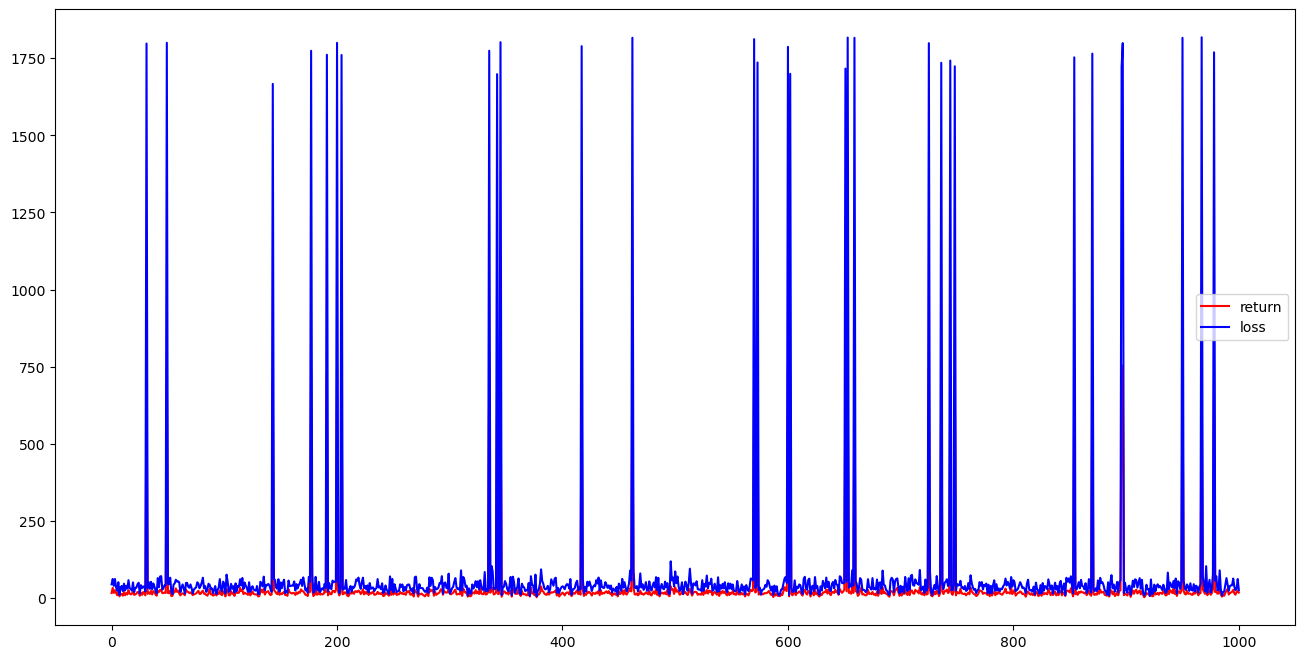

  1%|▎                                 | 1002/100000 [08:37<14:43:17,  1.87it/s]


Loss > 500 at episode  1002
tensor([[[11],
         [43],
         [20],
         [98],
         [30]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        ...,

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [21.,  1.,  1.,  1., -1.],
        [20.,  0.,  0.,  0.,  0.],
        ...,
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.]])
tensor([[3.6950e+03, 1.0000e+00, 9.0000e+00, 1.9000e+01, 1.7000e+01],
        [3.6950e+03, 1.0000e+00, 9.0000e+00, 1.9000e+01, 1.7000e+01],
        [3.6740e+03, 0.0000e+00, 8.0000e+00, 1.8000e+01, 1.8000e+01],
        ...,
        [6.0000e+01, 0.0000e+00, 0.0000e+00, 0.0

  1%|▍                                 | 1110/100000 [09:34<14:03:30,  1.95it/s]


Loss > 500 at episode  1110
tensor([[[ 12],
         [  6],
         [127],
         [ 86],
         [ 15]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 81],
         [ 12],
         [109],
         [ 41],
         [105]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1., 21.,  1.],
        [ 0.,  0.,  0., 20.,  0.],
        ...,
        [ 0.,  0.,  0., 20.,  0.],
        [ 1., -1.,  1.,  0.,  1.],
        [ 1.,  1.,  1., 21.,  1.]])
tensor([[3.4000e+01, 1.0000e+01, 2.2000e+01, 3.6400e+03, 1.8000e+01],
        [3.4000e+01, 1.0000e+01, 2.2000e+01, 3.6400e+03, 1.8000e+01],
        [3.3000e+01, 9.0000e+00, 2.1000e+01, 3.6190e+03, 1.7000e+01],
        ...,
        [2.0000e+0

  1%|▍                                 | 1127/100000 [09:43<14:17:56,  1.92it/s]


Loss > 500 at episode  1127
tensor([[[ 46],
         [ 55],
         [104],
         [ 73],
         [ 41]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1., 21., -1.],
        [ 0.,  0.,  0., 20.,  0.],
        ...,
        [ 0.,  0.,  0., 20.,  0.],
        [ 0.,  0.,  0., 20.,  0.],
        [ 0.,  0.,  0., 20.,  0.]])
tensor([[   7.,    5.,   19., 3602.,   48.],
        [   7.,    5.,   19., 3602.,   48.],
        [   6.,    4.,   18., 3581.,   49.],
        ...,
        [   0.,    0.,    0.,   60.,    0.],
        [   0.,    0.,    0.,   40.,    0.],
   

  1%|▍                                 | 1170/100000 [10:05<14:06:23,  1.95it/s]


Loss > 500 at episode  1170
tensor([[[ 56],
         [ 22],
         [ 82],
         [ 29],
         [ 55]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 21],
         [ 10],
         [ 90],
         [106],
         [ 13]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [-1.,  1., 21.,  1.,  1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [-1., -1.,  0., -1.,  1.],
        [ 1.,  1., 21.,  1.,  1.]])
tensor([[2.0000e+01, 2.9000e+01, 3.6400e+03, 5.0000e+00, 5.0000e+00],
        [2.0000e+01, 2.9000e+01, 3.6400e+03, 5.0000e+00, 5.0000e+00],
        [2.1000e+01, 2.8000e+01, 3.6190e+03, 4.0000e+00, 4.0000e+00],
        ...,
        [0.0000e+0

  1%|▍                                 | 1203/100000 [10:22<14:41:57,  1.87it/s]


Loss > 500 at episode  1203
tensor([[[64],
         [63],
         [12],
         [14],
         [45]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        ...,

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1., 21.,  1.,  1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.],
        [ 0.,  0., 20.,  0.,  0.]])
tensor([[   5.,   19., 3617.,    9.,   21.],
        [   5.,   19., 3617.,    9.,   21.],
        [   4.,   18., 3596.,    8.,   20.],
        ...,
        [   0.,    0.,   60.,    0.,    0.],
        [   0.,    0.,   40.,    0.,    0.],
        [   0.,    0.,   20.,    

  1%|▍                                 | 1246/100000 [10:45<14:03:24,  1.95it/s]


Loss > 500 at episode  1246
tensor([[[119],
         [101],
         [112],
         [  6],
         [ 46]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1., 21., -1.],
        [ 0.,  0.,  0., 20.,  0.],
        ...,
        [ 0.,  0.,  0., 20.,  0.],
        [ 0.,  0.,  0., 20.,  0.],
        [ 0.,  0.,  0., 20.,  0.]])
tensor([[ 0.0000e+00,  0.0000e+00,  2.0000e+01,  3.5810e+03,  2.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  2.0000e+01,  3.5810e+03,  2.0000e+00],
        [-1.0000e+00, -1.0000e+00,  1.9000e+01,  3.5600e+03,  3.0000e+00],
        ...,
   

  1%|▍                                 | 1273/100000 [10:59<14:01:55,  1.95it/s]


Loss > 500 at episode  1273
tensor([[[ 89],
         [125],
         [ 51],
         [ 44],
         [ 27]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 99],
         [ 37],
         [109],
         [101],
         [ 67]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1., 21., -1.,  1.],
        [ 0.,  0., 20.,  0.,  0.],
        ...,
        [ 0.,  0., 20.,  0.,  0.],
        [-1., -1.,  0.,  1., -1.],
        [ 1.,  1., 21.,  1.,  1.]])
tensor([[1.0000e+01, 4.0000e+00, 3.6360e+03, 1.8000e+01, 8.0000e+00],
        [1.0000e+01, 4.0000e+00, 3.6360e+03, 1.8000e+01, 8.0000e+00],
        [9.0000e+00, 3.0000e+00, 3.6150e+03, 1.9000e+01, 7.0000e+00],
        ...,
        [0.0000e+0

  1%|▍                                 | 1282/100000 [11:03<14:03:56,  1.95it/s]


Loss > 500 at episode  1282
tensor([[[109],
         [116],
         [118],
         [ 44],
         [ 32]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [21.,  1.,  1., -1.,  1.],
        [20.,  0.,  0.,  0.,  0.],
        ...,
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.],
        [20.,  0.,  0.,  0.,  0.]])
tensor([[3.6760e+03, 2.0000e+00, 2.0000e+00, 3.3000e+01, 2.0000e+00],
        [3.6760e+03, 2.0000e+00, 2.0000e+00, 3.3000e+01, 2.0000e+00],
        [3.6550e+03, 1.0000e+00, 1.0000e+00, 3.4000e+01, 1.0000e+00],
        ...,
        [6.0000e+0

  1%|▍                                 | 1293/100000 [11:09<14:04:50,  1.95it/s]


Loss > 500 at episode  1293
tensor([[[114],
         [ 58],
         [  6],
         [ 66],
         [ 96]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 38],
         [112],
         [115],
         [ 35],
         [ 57]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1., 21.,  1.,  1.,  1.],
        [ 0., 20.,  0.,  0.,  0.],
        ...,
        [ 0., 20.,  0.,  0.,  0.],
        [ 0., 20.,  0.,  0.,  0.],
        [ 1.,  0.,  1.,  1.,  1.]])
tensor([[1.7000e+01, 3.5420e+03, 1.7000e+01, 2.9000e+01, 2.0000e+01],
        [1.7000e+01, 3.5420e+03, 1.7000e+01, 2.9000e+01, 2.0000e+01],
        [1.6000e+01, 3.5210e+03, 1.6000e+01, 2.8000e+01, 1.9000e+01],
        ...,
        [1.0000e+0

  1%|▍                                 | 1318/100000 [11:22<14:27:31,  1.90it/s]


Loss > 500 at episode  1318
tensor([[[88],
         [39],
         [12],
         [22],
         [ 7]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        ...,

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [-1.,  1.,  1., -1., 21.],
        [ 0.,  0.,  0.,  0., 20.],
        ...,
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.]])
tensor([[1.0000e+01, 2.4000e+01, 2.0000e+00, 0.0000e+00, 3.5600e+03],
        [1.0000e+01, 2.4000e+01, 2.0000e+00, 0.0000e+00, 3.5600e+03],
        [1.1000e+01, 2.3000e+01, 1.0000e+00, 1.0000e+00, 3.5390e+03],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0

  1%|▍                                 | 1393/100000 [12:00<13:50:15,  1.98it/s]


Loss > 500 at episode  1393
tensor([[[102],
         [  3],
         [112],
         [110],
         [ 26]],

        [[ 10],
         [ 74],
         [ 50],
         [ 31],
         [ 56]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        ...,

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]],

        [[ 26],
         [ 26],
         [ 26],
         [ 26],
         [ 26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  0.],
        [-1., -1., -1.,  1., 21.],
        ...,
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.],
        [ 0.,  0.,  0.,  0., 20.]])
tensor([[2.0000e+00, 8.0000e+00, 3.5000e+01, 3.0000e+00, 3.6370e+03],
        [2.0000e+00, 8.0000e+00, 3.5000e+01, 3.0000e+00, 3.6370e+03],
        [1.0000e+00, 7.0000e+00, 3.4000e+01, 2.0000e+00, 3.6370e+03],
        ...,
        [0.0000e+0

  1%|▍                                 | 1430/100000 [12:19<13:55:31,  1.97it/s]


Loss > 500 at episode  1430
tensor([[[17],
         [67],
         [90],
         [28],
         [57]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        ...,

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]],

        [[26],
         [26],
         [26],
         [26],
         [26]]])
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 1., -1.,  1., 21.,  1.],
        [ 0.,  0.,  0., 20.,  0.],
        ...,
        [ 1., -1.,  0., 21., -1.],
        [ 0.,  0.,  0., 20.,  0.],
        [ 0.,  0.,  0., 20.,  0.]])
tensor([[ 3.8000e+01,  1.0000e+01,  2.2000e+01,  3.5260e+03,  5.2000e+01],
        [ 3.8000e+01,  1.0000e+01,  2.2000e+01,  3.5260e+03,  5.2000e+01],
        [ 3.7000e+01,  1.1000e+01,  2.1000e+01,  3.5050e+03,  5.1000e+01],
        ...,
        [ 1.0000e+00, -1.0000e+00

  1%|▍                                 | 1453/100000 [12:31<14:09:39,  1.93it/s]


KeyboardInterrupt: 

In [29]:
episode_count = 100_000
episode_length = 200

batch_size = 5

for episode_number in tqdm(range(episode_count)):
    
    start_sample = chord_dataset.sample_batch(batch_size=batch_size)
    final_sample = chord_dataset.sample_batch(batch_size=batch_size)
    
    agent = Agent(chord_size=chord_size,
                  starting_chord_batch=start_sample,
                 final_chord_batch=final_sample,
                 policy=policy,
                 rewards=AllRewards(progress_to_closing, closing_chord),
                 chord_dataset=chord_dataset)
    
    learning_rate = 1e-7
    optimizer = torch.optim.SGD(policy.parameters(), lr = learning_rate)
    
    for n in range(episode_length):
        agent.time_step(noise_probability=.1)
        
    optimizer.zero_grad()

    full_policy_batch = agent.specific_policy_batch
    full_return_batch = agent.episode_returns_batch

    loss = -full_return_batch * torch.log(full_policy_batch)
    mean_return = torch.mean(full_return_batch[0])
    loss = torch.mean(loss)
    
    if loss > 500:
        print('\nLoss > 500 at episode ', episode_number)
        print(agent.episode_states_batch)
        print(agent.episode_rewards_batch)
        print(agent.episode_returns_batch)

    loss.backward()

    optimizer.step()

    episode_loss = loss.item()
    episode_return = mean_return.item()
    
    loss_values.append(episode_loss)
    return_values.append(episode_return)

    if episode_number>0 and episode_number%500==0:
        fig = plt.figure(frameon=False)
        fig.set_size_inches(16, 8)
        plt.plot(return_values, color='red', label ='return')
        plt.plot(loss_values, color='blue', label ='loss')
        plt.legend()
        plt.show()

In [ ]:
fig = plt.figure(frameon=False)
fig.set_size_inches(16, 8)
plt.plot(loss_values, color='blue', label ='loss')
plt.plot(return_values, color='red', label ='return')
plt.legend()
plt.show()